In [1]:
import numpy as np
import pandas as pd
import time

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, cross_validate

from math import sqrt
import seaborn as sns
import matplotlib.pyplot as plt

import datasource_config

In [2]:
# Reading the feature_extracts dataset for modeling.
# using config file for source data path
path = datasource_config.CLASSIFICATION_SOURCE_DATA_PATH

phm_df = pd.read_parquet(path, engine='fastparquet')

In [3]:
# The below logic will split the 3 sensors array columns into separate 571 columns each.
phm_split_df = None
for i, sensor in enumerate(['pdmp', 'pin', 'po']):
    temp_split_df = phm_df[sensor].apply(pd.Series)
    temp_split_df.columns = [sensor + '_' + str(x) for x in range(1, 572)]

    if (i == 0):
        phm_split_df = pd.concat([phm_df[['index', 'fault_class', 'individual']], temp_split_df], axis=1)
        print("Length of phm_split_df.columns: ", len(phm_split_df.columns))
    else:
        phm_split_df = pd.concat([phm_split_df, temp_split_df], axis=1)
        print("Length of phm_split_df.columns: ", len(phm_split_df.columns))
phm_split_df.columns

Length of phm_split_df.columns:  574
Length of phm_split_df.columns:  1145
Length of phm_split_df.columns:  1716


Index(['index', 'fault_class', 'individual', 'pdmp_1', 'pdmp_2', 'pdmp_3',
       'pdmp_4', 'pdmp_5', 'pdmp_6', 'pdmp_7',
       ...
       'po_562', 'po_563', 'po_564', 'po_565', 'po_566', 'po_567', 'po_568',
       'po_569', 'po_570', 'po_571'],
      dtype='object', length=1716)

In [4]:
phm_df = phm_split_df
phm_df

,index,fault_class,individual,pdmp_1,pdmp_2,pdmp_3,pdmp_4,pdmp_5,pdmp_6,pdmp_7,...,po_562,po_563,po_564,po_565,po_566,po_567,po_568,po_569,po_570,po_571
0,22776,3,5,-0.194942,-0.187465,-0.180348,-0.173447,-0.168120,-0.164938,-0.162964,...,1.050622,1.034456,1.006829,0.981712,0.982890,0.995431,0.997414,0.981866,0.969041,0.971418
1,22777,8,5,-0.246213,-0.273524,-0.308485,-0.348401,-0.388465,-0.423755,-0.450124,...,0.912746,0.908318,0.922986,0.935062,0.936170,0.941296,0.953447,0.959849,0.951849,0.934557
2,22778,4,5,0.276173,0.256051,0.233923,0.207697,0.179566,0.149646,0.118753,...,0.921702,0.926112,0.928393,0.930782,0.940371,0.956150,0.957770,0.939279,0.927833,0.935658
3,22779,2,5,0.065800,0.057669,0.051469,0.047736,0.045938,0.047479,0.052721,...,0.422891,0.428285,0.432260,0.430246,0.419753,0.400856,0.375741,0.351293,0.335347,0.331829
4,22780,2,5,0.277680,0.272525,0.265093,0.256061,0.246930,0.238751,0.234863,...,0.388398,0.383101,0.390316,0.395677,0.395287,0.384548,0.363969,0.339599,0.317733,0.305070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34140,34141,1,6,-0.051017,-0.055426,-0.061033,-0.070764,-0.087975,-0.112000,-0.141544,...,0.945983,0.945088,0.944416,0.952775,0.959355,0.946094,0.927905,0.931097,0.954974,0.976086
34141,34142,1,6,0.027704,0.008840,-0.005844,-0.015680,-0.020587,-0.017767,-0.007995,...,0.948468,0.960261,0.954239,0.927050,0.902973,0.902458,0.920599,0.937222,0.946607,0.952880
34142,34143,1,6,-0.037775,-0.053561,-0.073233,-0.097449,-0.124788,-0.155356,-0.188065,...,0.951262,0.939103,0.912608,0.901967,0.918477,0.943463,0.955312,0.953058,0.956575,0.964654
34143,34144,1,6,0.095459,0.086675,0.078642,0.068852,0.057889,0.044362,0.029811,...,0.915304,0.936355,0.945232,0.937995,0.914667,0.887997,0.889253,0.923887,0.949244,0.947865


In [5]:
# Split the data into features (X) and target (y)

X = phm_df.drop(['index', 'fault_class'], axis=1)
y = phm_df['fault_class']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train

,individual,pdmp_1,pdmp_2,pdmp_3,pdmp_4,pdmp_5,pdmp_6,pdmp_7,pdmp_8,pdmp_9,...,po_562,po_563,po_564,po_565,po_566,po_567,po_568,po_569,po_570,po_571
18732,1,-0.065192,-0.051737,-0.029919,-0.003134,0.029981,0.064803,0.100958,0.135416,0.167351,...,0.611353,0.637259,0.647332,0.640243,0.623459,0.612411,0.607392,0.604428,0.610368,0.630713
31553,6,-0.079127,-0.084061,-0.088600,-0.097031,-0.110011,-0.128265,-0.152310,-0.179802,-0.211092,...,0.899411,0.905413,0.930547,0.948133,0.948191,0.950478,0.961133,0.958985,0.938635,0.928151
30577,2,-0.006716,-0.004482,0.001138,0.012094,0.029292,0.052633,0.076709,0.096085,0.109307,...,1.131021,1.141744,1.141862,1.145348,1.144272,1.107316,1.067372,1.049508,1.041668,1.040290
27580,2,0.104245,0.091257,0.077709,0.067168,0.059777,0.059256,0.062103,0.064028,0.063349,...,0.579275,0.603458,0.620231,0.617988,0.598300,0.579645,0.574144,0.574524,0.576466,0.587230
21839,1,0.398848,0.404063,0.396452,0.377748,0.348419,0.311950,0.270431,0.226010,0.180170,...,0.604290,0.597207,0.597062,0.609692,0.631046,0.647476,0.649124,0.636582,0.624825,0.620626
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370,5,-0.384062,-0.410177,-0.437658,-0.463603,-0.481579,-0.489375,-0.487687,-0.477051,-0.466348,...,0.947515,0.957000,0.958656,0.941769,0.913977,0.898476,0.911251,0.932548,0.942165,0.947509
24597,2,0.067663,0.074857,0.082327,0.092718,0.106691,0.123114,0.138903,0.153193,0.163285,...,1.090363,1.100053,1.105419,1.105899,1.125943,1.152416,1.158143,1.141437,1.130706,1.140522
23115,2,-0.051079,-0.044050,-0.034900,-0.026550,-0.019365,-0.015466,-0.014728,-0.013985,-0.011127,...,1.104276,1.122105,1.136863,1.144245,1.156632,1.166881,1.166723,1.145569,1.104574,1.068590
1554,5,-0.113779,-0.132984,-0.149087,-0.166459,-0.188455,-0.215521,-0.244489,-0.272720,-0.295690,...,0.915935,0.906723,0.897694,0.887587,0.886276,0.896856,0.907885,0.899789,0.869598,0.849332


In [6]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [7]:
# get the start time
st = time.time()

# Train the knn classifier model.
knn_model.fit(X_train, y_train)

# get the end time
et = time.time()

# get the execution time
elapsed_time = et - st
print('Modelling training time:', elapsed_time, 'seconds')

Modelling training time: 0.7651150226593018 seconds


In [8]:
# Calculate Root-Mean-Squared Error using training data results.
train_preds = knn_model.predict(X_train)
mse = mean_squared_error(y_train, train_preds)
rmse = sqrt(mse)
rmse


0.5362807219542637

In [9]:
# Calculate Root-Mean-Squared Error using testing data results.
test_preds = knn_model.predict(X_test)
mse = mean_squared_error(y_test, test_preds)
rmse = sqrt(mse)
rmse


0.6551328142038035

In [10]:
# Calculate the Accuracy score for the test dataset:
y_pred = knn_model.predict(X_test)
y_pred

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9677844486747693


# CROSS-VALIDATION

In [11]:
# Initial Cross-Validation on KNN Classifier using Raw values:

k_values = [1, 2, 3, 8, 10, 12, 14]
train_accuracy_scores = []
test_accuracy_scores = []
test_f1_scores = []
test_recall_scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=4, weights='distance')

    # get the start time
    st = time.time()

    cv_results = cross_validate(knn, X, y, cv=5, scoring='accuracy', return_estimator=True)
    # get the end time
    et = time.time()

    # get the execution time
    elapsed_time = et - st
    print('Modelling training time:', elapsed_time, 'seconds')
    
    test_accuracy_score = cv_results['test_score']

    test_accuracy_scores.append(np.mean(test_accuracy_score))

    train_accuracy_score = []
    print('Running estimator for training scores')
    for estimator in cv_results['estimator']:
        train_accuracy_score.append(estimator.score(X, y))
    print('Training scores calculated!')
    train_accuracy_scores.append(np.mean(train_accuracy_score))

    print("For n_neighbors = ", k)
    print("Training Accuracy Score = ", np.mean(train_accuracy_score))
    print("Testing Accuracy Score = ", np.mean(test_accuracy_score))

# INFO: the weights is by default set to 'uniform'.
# RESULTS: k=9 has the best testing accuracy and k=2 has the worst. But seems to be slightly overfitted. (5% difference in test vs train accuracies)


Modelling training time: 44.76506996154785 seconds
Running estimator for training scores
Training scores calculated!
For n_neighbors =  1
Training Accuracy Score =  0.9859481622492312
Testing Accuracy Score =  0.929740811246156
Modelling training time: 42.78648495674133 seconds
Running estimator for training scores
Training scores calculated!
For n_neighbors =  2
Training Accuracy Score =  0.9859481622492312
Testing Accuracy Score =  0.929740811246156
Modelling training time: 43.88353776931763 seconds
Running estimator for training scores
Training scores calculated!
For n_neighbors =  3
Training Accuracy Score =  0.9857841558061209
Testing Accuracy Score =  0.9289207790306048
Modelling training time: 43.495694160461426 seconds
Running estimator for training scores
Training scores calculated!
For n_neighbors =  8
Training Accuracy Score =  0.9853858544442817
Testing Accuracy Score =  0.9269292722214088
Modelling training time: 43.61137104034424 seconds
Running estimator for training sco

In [13]:
# This cell is for tuning hyper-parameters of the KNeighborsClassifier().
# Setting weights='distance' in KNeighborsClassifier():
k_values = [i for i in range (1,15)]
k_values = [2, 3, 8, 9, 10]
train_accuracy_scores = []
test_accuracy_scores = []
test_f1_scores = []
test_recall_scores = []

scaler = StandardScaler()
X = scaler.fit_transform(X)

for k in k_values:
    print("For n_neighbors = ", k)
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=4, p=2)

    cv_results = cross_validate(knn, X, y, cv=5, scoring='accuracy', return_estimator=True)

    print('Modelling training time:', np.mean(cv_results['fit_time']), 'seconds')
    
    test_accuracy_score = cv_results['test_score']

    test_accuracy_scores.append(np.mean(test_accuracy_score))
    print("Training Accuracy Score = ", np.mean(train_accuracy_score))

    train_accuracy_score = []
    for estimator in cv_results['estimator']:
        train_accuracy_score.append(estimator.score(X, y))

    train_accuracy_scores.append(np.mean(train_accuracy_score))

    test_f1_score = cross_val_score(knn, X, y, cv=5, scoring='f1_weighted')
    test_f1_scores.append(np.mean(test_f1_score))

    test_recall_score = cross_val_score(knn, X, y, cv=5, scoring='recall_weighted')
    test_recall_scores.append(np.mean(test_recall_score))
    print("Testing Accuracy Score = ", np.mean(test_accuracy_score))

    
# RESULTS: Changing weights='distance' increased overfitting. The test vs train scores have a difference of ~10% as compared to ~5% with weights='uniform'

For n_neighbors =  2
Modelling training time: 0.672282600402832 seconds
Training Accuracy Score =  0.9842670962073509
Testing Accuracy Score =  0.919343974227559
For n_neighbors =  3
Modelling training time: 0.5810275554656983 seconds
Training Accuracy Score =  0.9776775516180993
Testing Accuracy Score =  0.9281007468150534
For n_neighbors =  8
Modelling training time: 0.6494070529937744 seconds
Training Accuracy Score =  0.9819124322741251
Testing Accuracy Score =  0.9200175721189046
For n_neighbors =  9
Modelling training time: 0.6367010116577149 seconds
Training Accuracy Score =  0.974631717674623
Testing Accuracy Score =  0.922038365792942
For n_neighbors =  10
Modelling training time: 0.5759992122650146 seconds
Training Accuracy Score =  0.9760843461707424
Testing Accuracy Score =  0.9187875237955776


Text(0, 0.5, 'Testing Accuracy Scores')

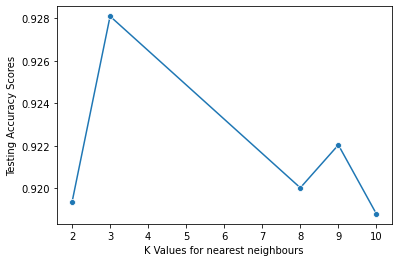

In [14]:
sns.lineplot(x = k_values, y = test_accuracy_scores, marker = 'o')
plt.xlabel("K Values for nearest neighbours")
plt.ylabel("Testing Accuracy Scores")


Text(0, 0.5, 'Training Accuracy Scores')

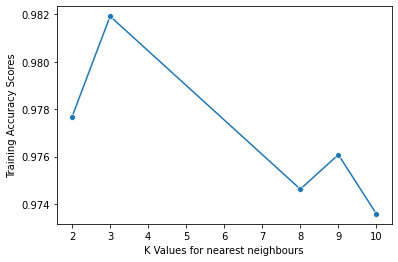

In [15]:
sns.lineplot(x = k_values, y = train_accuracy_scores, marker = 'o')
plt.xlabel("K Values for nearest neighbours")
plt.ylabel("Training Accuracy Scores")


Text(0, 0.5, 'Testing F1 Scores')

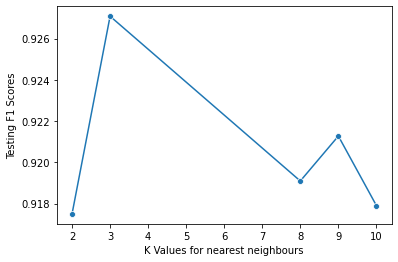

In [16]:
sns.lineplot(x = k_values, y = test_f1_scores, marker = 'o')
plt.xlabel("K Values for nearest neighbours")
plt.ylabel("Testing F1 Scores")


Text(0, 0.5, 'Testing Recall Scores')

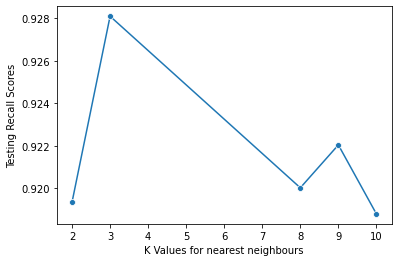

In [17]:
sns.lineplot(x = k_values, y = test_recall_scores, marker = 'o')
plt.xlabel("K Values for nearest neighbours")
plt.ylabel("Testing Recall Scores")


In [18]:
test_accuracy_scores

[0.919343974227559,
 0.9281007468150534,
 0.9200175721189046,
 0.922038365792942,
 0.9187875237955776]

In [19]:
print("Mean Testing Accuracy: ", np.mean(test_accuracy_scores))
print("Mean Training Accuracy: ", np.mean(test_accuracy_scores))
print("Mean f1: ", np.mean(test_f1_scores))
print("Mean recall: ", np.mean(test_recall_scores))

Mean Testing Accuracy:  0.9216576365500073
Mean Training Accuracy:  0.9216576365500073
Mean f1:  0.9205728180854171
Mean recall:  0.9216576365500073
